In [ ]:
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import os
import re
import matplotlib

# 1. 解决中文字体显示问题
try:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def natural_sort_key(s: str):
    """
    自然排序键函数，将字符串中的数字部分转换为整数进行比较
    例如: 'pca_10' 会排在 'pca_9' 后面
    """
    def convert(text):
        return int(text) if text.isdigit() else text.lower()
    
    def alphanum_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]
    
    return alphanum_key(s)

def sort_model_names(model_names: List[str]) -> List[str]:
    """
    对模型名称进行自然排序
    排序规则:
    1. 首先按类型分组 (Flux_VAE, SD_1_5_VAE)
    2. 在每个类型内按数字自然排序
    """
    # 分离不同类型的模型
    flux_models = [m for m in model_names if m.startswith('Flux_VAE')]
    sd_models = [m for m in model_names if m.startswith('SD_1_5_VAE')]
    other_models = [m for m in model_names if m not in flux_models + sd_models]
    
    # 对每种类型内的模型进行自然排序
    flux_models_sorted = sorted(flux_models, key=natural_sort_key)
    sd_models_sorted = sorted(sd_models, key=natural_sort_key)
    other_models_sorted = sorted(other_models, key=natural_sort_key)
    
    # 组合结果
    return flux_models_sorted + sd_models_sorted + other_models_sorted

def extract_pca_number(model_name: str) -> int:
    """
    从模型名称中提取PCA数字
    例如: 'Flux_VAE_pca_10' -> 10, 'Flux_VAE_original' -> 0
    """
    match = re.search(r'pca_(\d+)', model_name)
    if match:
        return int(match.group(1))
    elif 'original' in model_name:
        return 0
    else:
        return -1

def load_json_files(pattern: str = "vae_reconstruction_metrics_*.json") -> Dict[str, Dict]:
    """
    加载所有匹配模式的JSON文件
    """
    files = glob.glob(pattern)
    data_dict = {}
    
    print(f"Found {len(files)} JSON files:")
    for file in sorted(files):
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                filename = os.path.basename(file)
                model_name = filename.replace('vae_reconstruction_metrics_', '').replace('.json', '')
                data_dict[model_name] = data
                print(f"  ✓ {filename} -> {model_name}")
        except Exception as e:
            print(f"  ✗ Error loading {file}: {e}")
    
    return data_dict

def create_comparison_dataframe(data_dict: Dict[str, Dict]) -> pd.DataFrame:
    """
    将JSON数据转换为对比DataFrame，按自然顺序排序
    """
    # 获取模型名称并按自然顺序排序
    model_names = list(data_dict.keys())
    sorted_model_names = sort_model_names(model_names)
    
    print("\n📊 Model sorting:")
    print(f"Original order: {model_names[:5]}...")
    print(f"Sorted order: {sorted_model_names}")
    
    records = []
    
    for model_name in sorted_model_names:
        metrics = data_dict[model_name]
        record = {'Model': model_name}
        
        # 提取PCA编号（用于后续排序）
        pca_num = extract_pca_number(model_name)
        record['pca_number'] = pca_num
        
        for key, value in metrics.items():
            record[key] = value
        records.append(record)
    
    df = pd.DataFrame(records)
    
    # 确保按照正确的顺序
    df['sort_key'] = df['Model'].apply(natural_sort_key)
    df = df.sort_values('sort_key').drop('sort_key', axis=1)
    
    return df

def create_model_groups(df: pd.DataFrame) -> Dict[str, List[str]]:
    """
    根据模型名称创建分组
    """
    groups = {}
    
    for model_name in df['Model'].tolist():
        if 'Flux_VAE' in model_name:
            if 'original' in model_name:
                group_name = 'Flux_VAE (Original)'
            elif 'pca' in model_name:
                pca_num = extract_pca_number(model_name)
                group_name = f'Flux_VAE (PCA {pca_num})'
            else:
                group_name = 'Flux_VAE'
        elif 'SD_1_5_VAE' in model_name:
            if 'original' in model_name:
                group_name = 'SD 1.5 VAE (Original)'
            else:
                group_name = 'SD 1.5 VAE'
        else:
            group_name = 'Other'
        
        if group_name not in groups:
            groups[group_name] = []
        groups[group_name].append(model_name)
    
    return groups

def plot_metric_comparison(df: pd.DataFrame, metrics: List[str], 
                          metric_names: List[str] = None,
                          figsize=(16, 10)):
    """
    绘制多个指标的对比图，按正确顺序显示
    """
    if metric_names is None:
        metric_names = metrics
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # 获取按自然顺序排序的模型列表
    models = df['Model'].tolist()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx]
        
        std_metric = f"{metric.split('_')[0]}_std" if '_mean' in metric else f"{metric}_std"
        
        values = df[metric].tolist()
        
        # 创建颜色映射，按模型类型分组
        colors = []
        for model in models:
            if 'Flux_VAE_original' in model:
                colors.append('#1f77b4')  # 蓝色 - 原始模型
            elif 'Flux_VAE_pca' in model:
                pca_num = extract_pca_number(model)
                # PCA模型使用渐变色
                if pca_num <= 5:
                    colors.append('#ff7f0e')  # 橙色 - 低PCA
                elif pca_num <= 10:
                    colors.append('#2ca02c')  # 绿色 - 中PCA
                else:
                    colors.append('#d62728')  # 红色 - 高PCA
            elif 'SD_1_5_VAE' in model:
                colors.append('#9467bd')  # 紫色 - SD模型
            else:
                colors.append('#8c564b')  # 棕色 - 其他
        
        x_pos = np.arange(len(models))
        width = 0.6
        
        if std_metric in df.columns:
            errors = df[std_metric].tolist()
            bars = ax.bar(x_pos, values, width=width, yerr=errors, 
                         capsize=4, alpha=0.8, edgecolor='black', linewidth=1)
        else:
            bars = ax.bar(x_pos, values, width=width, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 设置颜色
        for i, bar in enumerate(bars):
            bar.set_color(colors[i])
        
        ax.set_title(f'{metric_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Model', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.set_xticks(x_pos)
        
        # 旋转x轴标签，避免重叠
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
        
        # 添加数值标签
        for i, (v, bar) in enumerate(zip(values, bars)):
            height = bar.get_height()
            y_offset = max(values) * 0.02
            ax.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                   f'{v:.4f}', ha='center', va='bottom', fontsize=8)
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        # 根据指标类型添加优化方向说明
        if 'mse' in metric or 'lpips' in metric:
            ax.annotate('Lower is better', xy=(0.98, 0.98), xycoords='axes fraction',
                       ha='right', va='top', fontsize=8, color='red', fontweight='bold')
        else:
            ax.annotate('Higher is better', xy=(0.98, 0.98), xycoords='axes fraction',
                       ha='right', va='top', fontsize=8, color='green', fontweight='bold')
        
        # 调整y轴范围，为标签留出空间
        ax.set_ylim(0, max(values) * 1.15)
    
    # 隐藏多余的子图
    for idx in range(n_metrics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('VAE Models Reconstruction Metrics Comparison (Natural Order)', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_trend_analysis(df: pd.DataFrame, metrics: List[str],
                       metric_names: List[str] = None):
    """
    绘制PCA维度变化的趋势图
    """
    if metric_names is None:
        metric_names = metrics
    
    # 分离Flux VAE PCA模型
    pca_models = df[df['Model'].str.contains('Flux_VAE_pca')].copy()
    if len(pca_models) == 0:
        print("No PCA models found for trend analysis")
        return
    
    # 提取PCA编号并排序
    pca_models['pca_num'] = pca_models['Model'].apply(extract_pca_number)
    pca_models = pca_models.sort_values('pca_num')
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        x = pca_models['pca_num']
        y = pca_models[metric]
        
        # 绘制折线图
        ax.plot(x, y, 'o-', linewidth=2.5, markersize=8, 
                markerfacecolor='white', markeredgewidth=2, color='#2ca02c')
        
        # 添加数据点标签
        for xi, yi in zip(x, y):
            ax.annotate(f'{yi:.4f}', xy=(xi, yi), xytext=(0, 8),
                       textcoords='offset points', ha='center', fontsize=8)
        
        ax.set_title(f'{metric_name} vs PCA Dimension', fontsize=12, fontweight='bold')
        ax.set_xlabel('PCA Dimension', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 设置x轴刻度
        ax.set_xticks(x)
        ax.set_xticklabels([f'PCA {int(xi)}' for xi in x])
        
        # 添加趋势线
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "--", color='red', alpha=0.5, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
            ax.legend(fontsize=8)
    
    # 隐藏多余的子图
    for idx in range(len(metrics), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Trend Analysis: Metrics vs PCA Dimension', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def create_grouped_comparison(df: pd.DataFrame):
    """
    创建分组比较图
    """
    # 创建分组
    groups = create_model_groups(df)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    
    metrics = ['mse_mean', 'psnr_mean', 'ssim_mean', 'lpips_mean']
    metric_names = ['MSE', 'PSNR', 'SSIM', 'LPIPS']
    
    for idx, (ax, metric, metric_name) in enumerate(zip(axes, metrics, metric_names)):
        # 为每个分组绘制
        x_labels = []
        group_values = []
        group_colors = []
        
        color_idx = 0
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        
        for group_name, model_names in groups.items():
            for model_name in model_names:
                if model_name in df['Model'].values:
                    value = df.loc[df['Model'] == model_name, metric].values[0]
                    x_labels.append(f"{group_name}\n{model_name.split('_')[-1]}")
                    group_values.append(value)
                    group_colors.append(colors[color_idx % len(colors)])
            color_idx += 1
        
        bars = ax.bar(range(len(x_labels)), group_values, color=group_colors, 
                     alpha=0.8, edgecolor='black')
        
        ax.set_title(f'{metric_name}', fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
        
        # 添加数值标签
        for bar, value in zip(bars, group_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(group_values)*0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=7)
    
    plt.suptitle('Grouped Model Comparison', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# 主程序
def main():
    print("=" * 80)
    print("VAE RECONSTRUCTION METRICS VISUALIZATION AND COMPARISON")
    print("=" * 80)
    
    # 1. 加载JSON文件
    print("\n📂 STEP 1: Loading JSON files...")
    data_dict = load_json_files("vae_reconstruction_metrics_*.json")
    
    if not data_dict:
        print("No JSON files found! Please check the file pattern.")
        return
    
    # 2. 创建DataFrame（使用自然排序）
    print("\n📊 STEP 2: Creating comparison dataframe with natural sorting...")
    df = create_comparison_dataframe(data_dict)
    
    print("\n📋 Sorted Model Order:")
    for i, model in enumerate(df['Model'].tolist(), 1):
        print(f"  {i:2d}. {model}")
    
    print("\n📋 Data Overview:")
    print(df.to_string())
    
    # 3. 显示分组信息
    print("\n📊 Model Groups:")
    groups = create_model_groups(df)
    for group_name, model_names in groups.items():
        print(f"  {group_name}: {len(model_names)} models")
    
    # 4. 定义要比较的指标
    mean_metrics = ['mse_mean', 'psnr_mean', 'ssim_mean', 'lpips_mean']
    metric_names = ['MSE (Lower better)', 'PSNR (Higher better)', 
                   'SSIM (Higher better)', 'LPIPS (Lower better)']
    
    # 5. 绘制柱状图（按自然顺序）
    print("\n📈 STEP 3: Creating bar chart comparison (natural order)...")
    plot_metric_comparison(df, mean_metrics, metric_names)
    
    # 6. 绘制趋势分析图
    print("\n📈 STEP 4: Creating trend analysis for PCA models...")
    plot_trend_analysis(df, mean_metrics, metric_names)
    
    # 7. 绘制分组比较图
    print("\n📊 STEP 5: Creating grouped comparison...")
    create_grouped_comparison(df)
    
    # 8. 保存结果
    print("\n💾 STEP 6: Saving results...")
    
    # 保存排序后的数据
    df.to_csv('vae_models_comparison_sorted.csv', index=False, encoding='utf-8-sig')
    
    # 保存分组信息
    with open('model_groups.json', 'w', encoding='utf-8') as f:
        json.dump(groups, f, indent=2, ensure_ascii=False)
    
    print("   ✓ vae_models_comparison_sorted.csv")
    print("   ✓ model_groups.json")
    
    # 9. 显示最佳模型
    print("\n🏆 BEST MODELS FOR EACH METRIC:")
    for metric, metric_name in zip(mean_metrics, ['MSE', 'PSNR', 'SSIM', 'LPIPS']):
        if 'mse' in metric or 'lpips' in metric:
            best_row = df.loc[df[metric].idxmin()]
        else:
            best_row = df.loc[df[metric].idxmax()]
        
        print(f"  {metric_name}: {best_row['Model']} = {best_row[metric]:.6f}")
    
    print("\n" + "=" * 80)
    print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    
    return df

# 执行主程序
if __name__ == "__main__":
    result_df = main()
    
    # 显示最终DataFrame
    print("\n📄 FINAL SORTED COMPARISON TABLE:")
    display(result_df.style
           .background_gradient(subset=['mse_mean', 'lpips_mean'], cmap='RdYlGn_r')
           .background_gradient(subset=['psnr_mean', 'ssim_mean'], cmap='RdYlGn')
           .format({'mse_mean': '{:.6f}', 'psnr_mean': '{:.6f}', 
                   'ssim_mean': '{:.6f}', 'lpips_mean': '{:.6f}'}))

VAE RECONSTRUCTION METRICS VISUALIZATION AND COMPARISON

📂 STEP 1: Loading JSON files from /workspace/VAE_SLIM/output...
Found 16 JSON files in /workspace/VAE_SLIM/output:
  ✓ /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_1/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_1.json
    -> Model: Flux_VAE_pca_single_iter_1
  ✓ /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_10/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_10.json
    -> Model: Flux_VAE_pca_single_iter_10
  ✓ /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_11/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_11.json
    -> Model: Flux_VAE_pca_single_iter_11
  ✓ /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_12/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_12.json
    -> Model: Flux_VAE_pca_single_iter_12
  ✓ /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_13/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_13.json
    -> Model: Flux_VAE_pca_single_iter_13
  ✓ /workspace/VAE_SLIM/ou

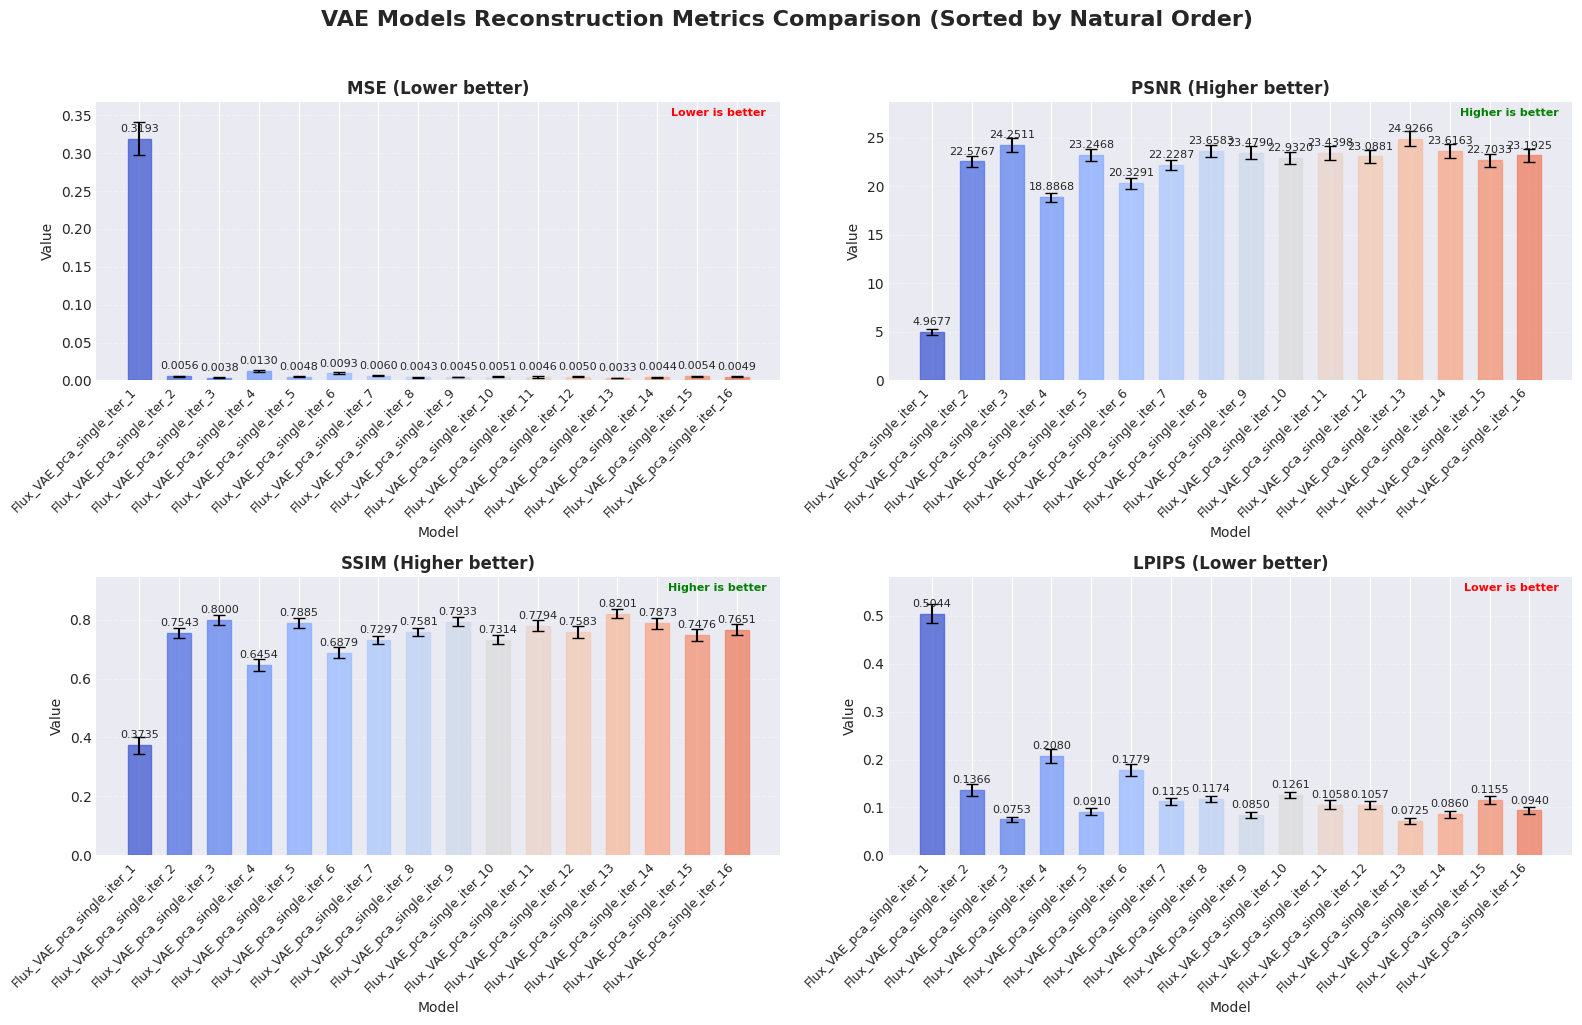


📈 STEP 4: Creating trend analysis for iteration models...


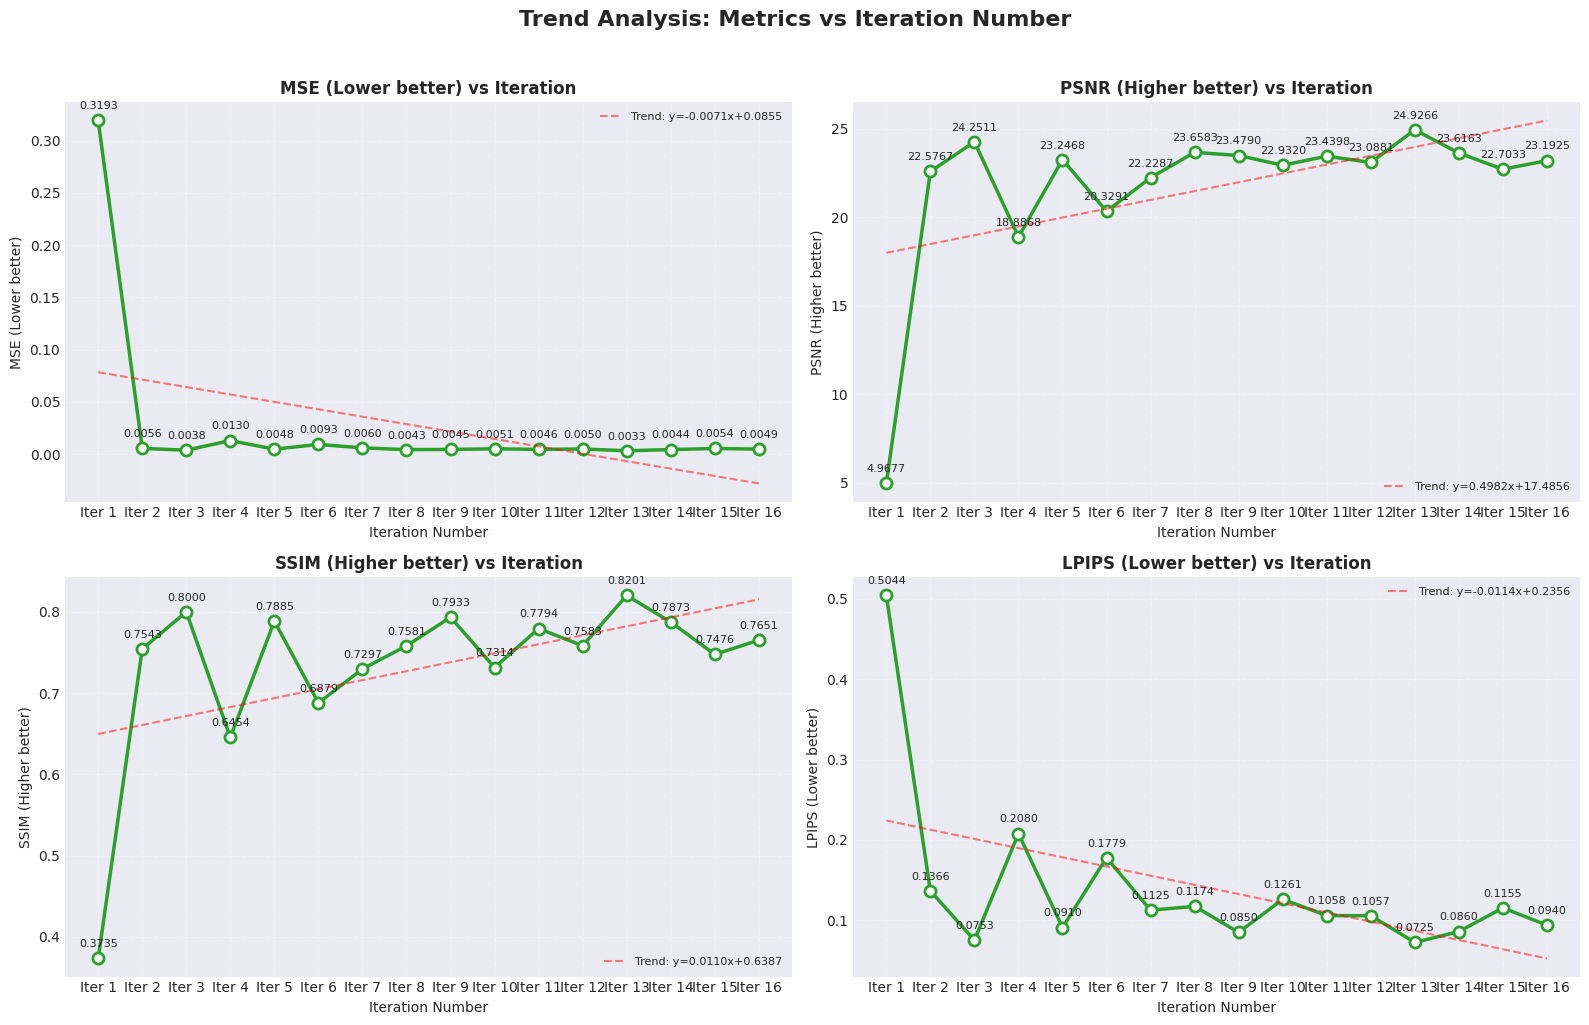


📊 STEP 5: Creating iteration comparison...


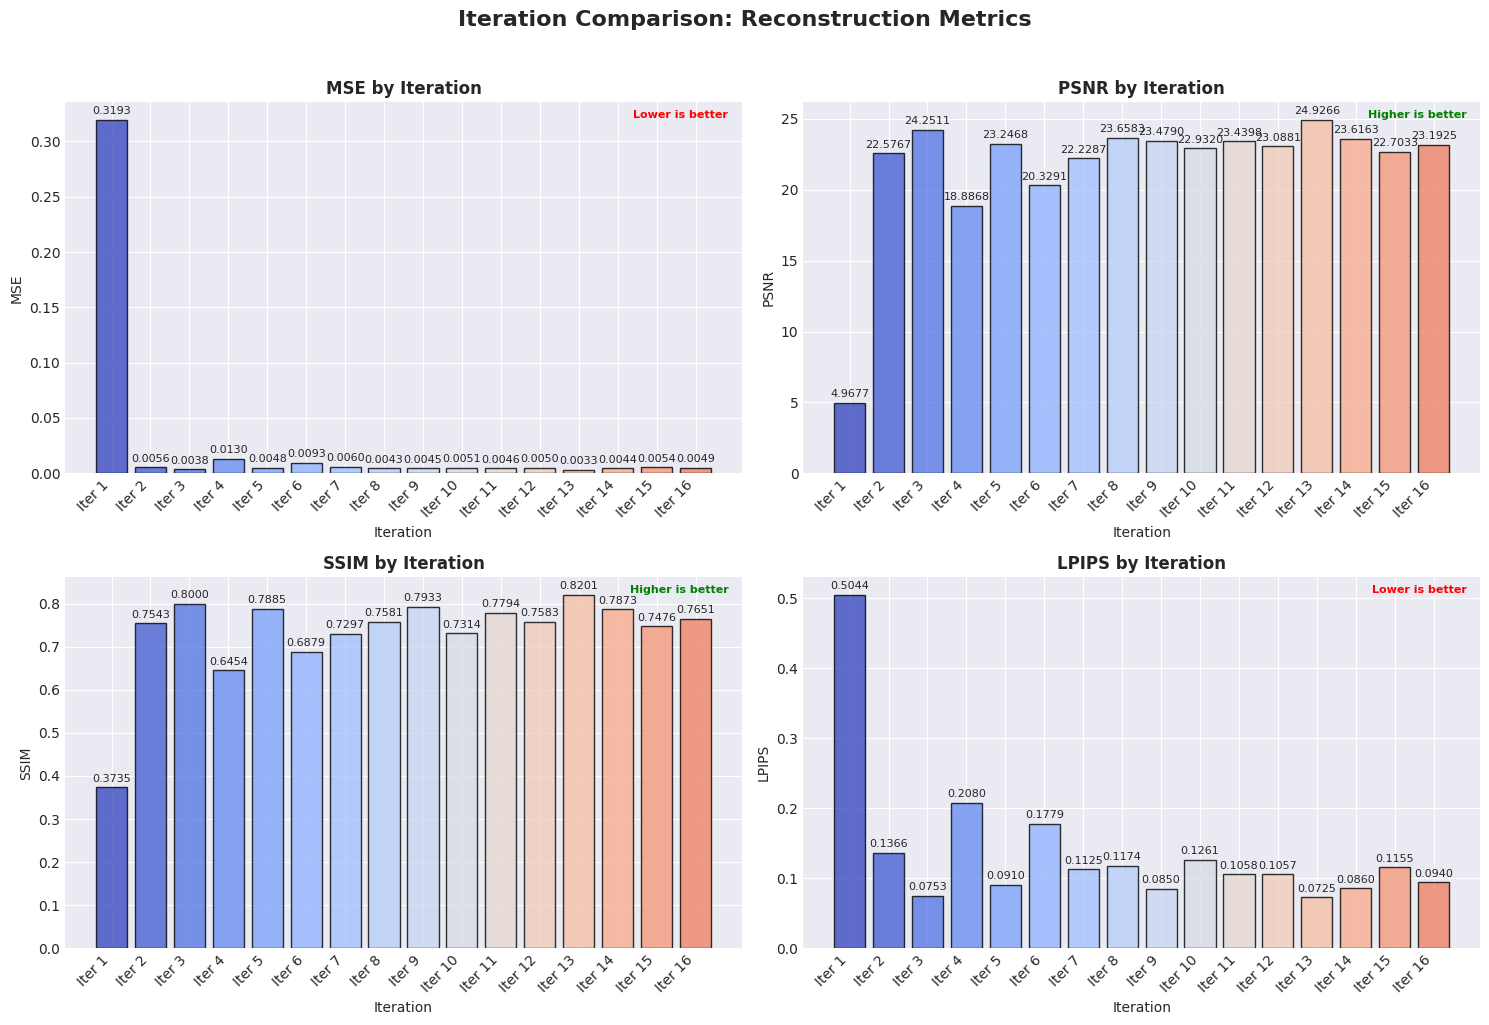


📋 STEP 6: Creating detailed metrics table...

📋 DETAILED METRICS TABLE:
                      Model  iteration mse_mean psnr_mean ssim_mean lpips_mean
 Flux_VAE_pca_single_iter_1          1 0.319345      4.97  0.373534   0.504350
 Flux_VAE_pca_single_iter_2          2 0.005577     22.58  0.754306   0.136615
 Flux_VAE_pca_single_iter_3          3 0.003808     24.25  0.799983   0.075261
 Flux_VAE_pca_single_iter_4          4 0.012997     18.89  0.645418   0.207990
 Flux_VAE_pca_single_iter_5          5 0.004784     23.25  0.788480   0.090972
 Flux_VAE_pca_single_iter_6          6 0.009346     20.33  0.687875   0.177914
 Flux_VAE_pca_single_iter_7          7 0.006027     22.23  0.729685   0.112547
 Flux_VAE_pca_single_iter_8          8 0.004348     23.66  0.758133   0.117389
 Flux_VAE_pca_single_iter_9          9 0.004539     23.48  0.793295   0.084961
Flux_VAE_pca_single_iter_10         10 0.005139     22.93  0.731437   0.126149
Flux_VAE_pca_single_iter_11         11 0.004588     23.44 

,Model,iteration,mse_mean,mse_std,psnr_mean,psnr_std,ssim_mean,ssim_std,lpips_mean,lpips_std,rfid
0,Flux_VAE_pca_single_iter_1,1,0.319345,0.021885,4.967688,0.299951,0.373534,0.027940,0.504350,0.020554,101.737656
1,Flux_VAE_pca_single_iter_2,2,0.005577,0.000754,22.576672,0.602862,0.754306,0.018354,0.136615,0.011842,15.464802
2,Flux_VAE_pca_single_iter_3,3,0.003808,0.000603,24.251078,0.719123,0.799983,0.017060,0.075261,0.005744,7.131277
3,Flux_VAE_pca_single_iter_4,4,0.012997,0.001386,18.886797,0.470310,0.645418,0.019928,0.207990,0.014740,32.437963
4,Flux_VAE_pca_single_iter_5,5,0.004784,0.000671,23.246832,0.634585,0.788480,0.017120,0.090972,0.007591,11.269240
5,Flux_VAE_pca_single_iter_6,6,0.009346,0.001198,20.329102,0.553221,0.687875,0.017879,0.177914,0.013022,24.854471
6,Flux_VAE_pca_single_iter_7,7,0.006027,0.000696,22.228666,0.514749,0.729685,0.013386,0.112547,0.006465,23.496300
7,Flux_VAE_pca_single_iter_8,8,0.004348,0.000584,23.658287,0.602326,0.758133,0.014039,0.117389,0.006817,13.303275
8,Flux_VAE_pca_single_iter_9,9,0.004539,0.000659,23.478962,0.657680,0.793295,0.016304,0.084961,0.006075,10.260723
9,Flux_VAE_pca_single_iter_10,10,0.005139,0.000690,22.931969,0.605168,0.731437,0.015419,0.126149,0.006873,15.715790


In [4]:
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import os
import re
import matplotlib

# 1. 解决中文字体显示问题
try:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def natural_sort_key(s: str):
    """
    自然排序键函数，将字符串中的数字部分转换为整数进行比较
    例如: 'Flux_VAE_pca_single_iter_10' 会排在 'Flux_VAE_pca_single_iter_9' 后面
    """
    def convert(text):
        return int(text) if text.isdigit() else text.lower()
    
    def alphanum_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]
    
    return alphanum_key(s)

def sort_model_names(model_names: List[str]) -> List[str]:
    """
    对模型名称进行自然排序
    """
    return sorted(model_names, key=natural_sort_key)

def extract_iteration_number(model_name: str) -> int:
    """
    从模型名称中提取迭代数字
    例如: 'Flux_VAE_pca_single_iter_1' -> 1, 'Flux_VAE_pca_single_iter_10' -> 10
    """
    match = re.search(r'iter_(\d+)', model_name)
    if match:
        return int(match.group(1))
    return -1

def load_json_files_from_output(base_path: str = "/workspace/VAE_SLIM/output") -> Dict[str, Dict]:
    """
    从/workspace/VAE_SLIM/output目录加载所有JSON文件
    新的文件路径格式:
    /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_1/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_1.json
    """
    # 使用glob搜索所有匹配的JSON文件
    pattern = os.path.join(base_path, "*/vae_reconstruction_metrics_*.json")
    files = glob.glob(pattern)
    data_dict = {}
    
    print(f"Found {len(files)} JSON files in {base_path}:")
    
    for file in sorted(files):
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
                # 从文件路径提取模型名称
                # 路径格式: /workspace/VAE_SLIM/output/Flux_VAE_pca_single_iter_1/vae_reconstruction_metrics_Flux_VAE_pca_single_iter_1.json
                # 我们要提取: Flux_VAE_pca_single_iter_1
                
                # 方法1: 从文件名中提取
                filename = os.path.basename(file)
                # 移除前缀和后缀
                model_name = filename.replace('vae_reconstruction_metrics_', '').replace('.json', '')
                
                # 方法2: 从目录名中提取（备选）
                dir_name = os.path.basename(os.path.dirname(file))
                
                # 验证模型名称是否匹配目录名
                if model_name != dir_name:
                    print(f"  ⚠️ Warning: Filename model '{model_name}' doesn't match directory '{dir_name}'")
                
                data_dict[model_name] = data
                print(f"  ✓ {file}")
                print(f"    -> Model: {model_name}")
                
        except Exception as e:
            print(f"  ✗ Error loading {file}: {e}")
    
    return data_dict

def create_comparison_dataframe(data_dict: Dict[str, Dict]) -> pd.DataFrame:
    """
    将JSON数据转换为对比DataFrame，按自然顺序排序
    """
    # 获取模型名称并按自然顺序排序
    model_names = list(data_dict.keys())
    sorted_model_names = sort_model_names(model_names)
    
    print("\n📊 Model sorting:")
    print(f"Original order: {model_names}")
    print(f"Sorted order: {sorted_model_names}")
    
    records = []
    
    for model_name in sorted_model_names:
        metrics = data_dict[model_name]
        record = {'Model': model_name}
        
        # 提取迭代编号（用于后续排序和分组）
        iter_num = extract_iteration_number(model_name)
        record['iteration'] = iter_num
        
        # 添加所有指标
        for key, value in metrics.items():
            record[key] = value
        
        records.append(record)
    
    df = pd.DataFrame(records)
    
    # 确保按照正确的顺序
    df['sort_key'] = df['Model'].apply(natural_sort_key)
    df = df.sort_values('sort_key').drop('sort_key', axis=1)
    
    return df

def create_model_groups(df: pd.DataFrame) -> Dict[str, List[str]]:
    """
    根据模型名称创建分组
    """
    groups = {}
    
    for model_name in df['Model'].tolist():
        # 检查模型类型
        if 'Flux_VAE' in model_name:
            if 'pca_single_iter' in model_name:
                iter_num = extract_iteration_number(model_name)
                group_name = f'Flux VAE PCA Single (Iter {iter_num})'
            else:
                group_name = 'Flux VAE'
        elif 'SD_1_5_VAE' in model_name:
            group_name = 'SD 1.5 VAE'
        else:
            group_name = 'Other'
        
        if group_name not in groups:
            groups[group_name] = []
        groups[group_name].append(model_name)
    
    return groups

def plot_metric_comparison(df: pd.DataFrame, metrics: List[str], 
                          metric_names: List[str] = None,
                          figsize=(16, 10)):
    """
    绘制多个指标的对比图，按正确顺序显示
    """
    if metric_names is None:
        metric_names = metrics
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # 获取按自然顺序排序的模型列表
    models = df['Model'].tolist()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # 尝试获取对应的标准差列
        std_metric = None
        if '_mean' in metric:
            base_metric = metric.replace('_mean', '')
            std_metric = f"{base_metric}_std"
        elif '_std' not in metric:
            std_metric = f"{metric}_std"
        
        values = df[metric].tolist()
        
        # 创建颜色映射，按迭代次数渐变
        colors = []
        max_iter = df['iteration'].max()
        
        for model in models:
            iter_num = extract_iteration_number(model)
            if iter_num > 0:
                # 根据迭代次数创建渐变色
                norm_iter = iter_num / max_iter if max_iter > 0 else 0
                # 使用蓝色到红色的渐变色
                color = plt.cm.coolwarm(norm_iter * 0.8)
                colors.append(color)
            else:
                colors.append('#8c564b')  # 棕色 - 无迭代信息
        
        x_pos = np.arange(len(models))
        width = 0.6
        
        if std_metric and std_metric in df.columns:
            errors = df[std_metric].tolist()
            bars = ax.bar(x_pos, values, width=width, yerr=errors, 
                         capsize=4, alpha=0.8, edgecolor='black', linewidth=1)
        else:
            bars = ax.bar(x_pos, values, width=width, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 设置颜色
        for i, bar in enumerate(bars):
            bar.set_color(colors[i])
        
        ax.set_title(f'{metric_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Model', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.set_xticks(x_pos)
        
        # 旋转x轴标签，避免重叠
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
        
        # 添加数值标签
        for i, (v, bar) in enumerate(zip(values, bars)):
            height = bar.get_height()
            y_offset = max(values) * 0.02
            ax.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                   f'{v:.4f}', ha='center', va='bottom', fontsize=8)
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        # 根据指标类型添加优化方向说明
        if 'mse' in metric.lower() or 'lpips' in metric.lower():
            ax.annotate('Lower is better', xy=(0.98, 0.98), xycoords='axes fraction',
                       ha='right', va='top', fontsize=8, color='red', fontweight='bold')
        elif 'psnr' in metric.lower() or 'ssim' in metric.lower():
            ax.annotate('Higher is better', xy=(0.98, 0.98), xycoords='axes fraction',
                       ha='right', va='top', fontsize=8, color='green', fontweight='bold')
        
        # 调整y轴范围，为标签留出空间
        ax.set_ylim(0, max(values) * 1.15)
    
    # 隐藏多余的子图
    for idx in range(n_metrics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('VAE Models Reconstruction Metrics Comparison (Sorted by Natural Order)', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_trend_analysis(df: pd.DataFrame, metrics: List[str],
                       metric_names: List[str] = None):
    """
    绘制迭代次数变化的趋势图
    """
    if metric_names is None:
        metric_names = metrics
    
    # 分离有迭代编号的模型
    iter_models = df[df['iteration'] > 0].copy()
    if len(iter_models) == 0:
        print("No iteration models found for trend analysis")
        return
    
    # 按迭代次数排序
    iter_models = iter_models.sort_values('iteration')
    
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        x = iter_models['iteration']
        y = iter_models[metric]
        
        # 绘制折线图
        ax.plot(x, y, 'o-', linewidth=2.5, markersize=8, 
                markerfacecolor='white', markeredgewidth=2, color='#2ca02c')
        
        # 添加数据点标签
        for xi, yi in zip(x, y):
            ax.annotate(f'{yi:.4f}', xy=(xi, yi), xytext=(0, 8),
                       textcoords='offset points', ha='center', fontsize=8)
        
        ax.set_title(f'{metric_name} vs Iteration', fontsize=12, fontweight='bold')
        ax.set_xlabel('Iteration Number', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 设置x轴刻度
        ax.set_xticks(x)
        ax.set_xticklabels([f'Iter {int(xi)}' for xi in x])
        
        # 添加趋势线
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "--", color='red', alpha=0.5, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
            ax.legend(fontsize=8)
    
    # 隐藏多余的子图
    for idx in range(len(metrics), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Trend Analysis: Metrics vs Iteration Number', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def create_iteration_comparison(df: pd.DataFrame):
    """
    创建迭代次数比较图
    """
    # 只选择有迭代次数的模型
    iter_df = df[df['iteration'] > 0].copy()
    if len(iter_df) == 0:
        print("No iteration models found for comparison")
        return
    
    iter_df = iter_df.sort_values('iteration')
    
    metrics = ['mse_mean', 'psnr_mean', 'ssim_mean', 'lpips_mean']
    metric_names = ['MSE', 'PSNR', 'SSIM', 'LPIPS']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx]
        
        x = iter_df['iteration']
        y = iter_df[metric]
        
        # 创建颜色渐变
        colors = plt.cm.coolwarm(np.linspace(0, 0.8, len(x)))
        
        bars = ax.bar(range(len(x)), y, color=colors, alpha=0.8, edgecolor='black')
        
        ax.set_title(f'{metric_name} by Iteration', fontsize=12, fontweight='bold')
        ax.set_xlabel('Iteration', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=10)
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels([f'Iter {i}' for i in x], rotation=45, ha='right')
        
        # 添加数值标签
        for bar, value in zip(bars, y):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(y)*0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=8)
        
        # 添加优化方向说明
        if 'mse' in metric or 'lpips' in metric:
            direction = 'Lower is better'
            color = 'red'
        else:
            direction = 'Higher is better'
            color = 'green'
        
        ax.annotate(direction, xy=(0.98, 0.98), xycoords='axes fraction',
                   ha='right', va='top', fontsize=8, color=color, fontweight='bold')
    
    plt.suptitle('Iteration Comparison: Reconstruction Metrics', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def create_detailed_table(df: pd.DataFrame):
    """
    创建详细的指标表格
    """
    print("\n📋 DETAILED METRICS TABLE:")
    print("=" * 120)
    
    # 选择要显示的列
    display_cols = ['Model', 'iteration', 'mse_mean', 'psnr_mean', 'ssim_mean', 'lpips_mean']
    
    # 确保所有列都存在
    available_cols = [col for col in display_cols if col in df.columns]
    
    display_df = df[available_cols].copy()
    
    # 格式化数值
    for col in ['mse_mean', 'ssim_mean', 'lpips_mean']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.6f}")
    
    if 'psnr_mean' in display_df.columns:
        display_df['psnr_mean'] = display_df['psnr_mean'].apply(lambda x: f"{x:.2f}")
    
    # 打印表格
    print(display_df.to_string(index=False))
    print("=" * 120)
    
    return display_df

# 主程序
def main():
    print("=" * 80)
    print("VAE RECONSTRUCTION METRICS VISUALIZATION AND COMPARISON")
    print("=" * 80)
    
    # 1. 从新的路径加载JSON文件
    print("\n📂 STEP 1: Loading JSON files from /workspace/VAE_SLIM/output...")
    data_dict = load_json_files_from_output("/workspace/VAE_SLIM/output")
    
    if not data_dict:
        print("No JSON files found! Please check the directory structure.")
        return
    
    # 2. 创建DataFrame（使用自然排序）
    print("\n📊 STEP 2: Creating comparison dataframe with natural sorting...")
    df = create_comparison_dataframe(data_dict)
    
    print("\n📋 Sorted Model Order:")
    for i, model in enumerate(df['Model'].tolist(), 1):
        iter_num = extract_iteration_number(model)
        print(f"  {i:2d}. {model} (Iter: {iter_num})")
    
    # 3. 显示数据概览
    print("\n📊 Data Overview:")
    print(f"Total models: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"Metrics available: {[col for col in df.columns if '_mean' in col]}")
    
    # 4. 显示分组信息
    print("\n📊 Model Groups:")
    groups = create_model_groups(df)
    for group_name, model_names in groups.items():
        print(f"  {group_name}: {len(model_names)} models")
    
    # 5. 定义要比较的指标
    mean_metrics = ['mse_mean', 'psnr_mean', 'ssim_mean', 'lpips_mean']
    metric_names = ['MSE (Lower better)', 'PSNR (Higher better)', 
                   'SSIM (Higher better)', 'LPIPS (Lower better)']
    
    # 6. 绘制柱状图（按自然顺序）
    print("\n📈 STEP 3: Creating bar chart comparison (natural order)...")
    plot_metric_comparison(df, mean_metrics, metric_names)
    
    # 7. 绘制趋势分析图
    print("\n📈 STEP 4: Creating trend analysis for iteration models...")
    plot_trend_analysis(df, mean_metrics, metric_names)
    
    # 8. 绘制迭代比较图
    print("\n📊 STEP 5: Creating iteration comparison...")
    create_iteration_comparison(df)
    
    # 9. 显示详细表格
    print("\n📋 STEP 6: Creating detailed metrics table...")
    detailed_df = create_detailed_table(df)
    
    # 10. 保存结果
    print("\n💾 STEP 7: Saving results...")
    
    # 保存排序后的数据
    output_dir = "/workspace/VAE_SLIM/analysis"
    os.makedirs(output_dir, exist_ok=True)
    
    output_csv = os.path.join(output_dir, 'vae_models_comparison_sorted.csv')
    output_json = os.path.join(output_dir, 'model_groups.json')
    
    df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    
    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(groups, f, indent=2, ensure_ascii=False)
    
    print(f"   ✓ Saved to {output_csv}")
    print(f"   ✓ Saved to {output_json}")
    
    # 11. 显示最佳模型
    print("\n🏆 BEST MODELS FOR EACH METRIC:")
    for metric, metric_name in zip(mean_metrics, ['MSE', 'PSNR', 'SSIM', 'LPIPS']):
        if 'mse' in metric or 'lpips' in metric:
            # 找最小值
            best_row = df.loc[df[metric].idxmin()]
        else:
            # 找最大值
            best_row = df.loc[df[metric].idxmax()]
        
        print(f"  {metric_name}: {best_row['Model']} = {best_row[metric]:.6f}")
    
    print("\n" + "=" * 80)
    print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    
    return df

# 执行主程序
if __name__ == "__main__":
    try:
        result_df = main()
        
        # 显示最终DataFrame
        print("\n📄 FINAL SORTED COMPARISON TABLE:")
        if 'mse_mean' in result_df.columns and 'lpips_mean' in result_df.columns:
            styled_df = result_df.style\
                .background_gradient(subset=['mse_mean', 'lpips_mean'], cmap='RdYlGn_r')\
                .background_gradient(subset=['psnr_mean', 'ssim_mean'], cmap='RdYlGn')\
                .format({
                    'mse_mean': '{:.6f}',
                    'psnr_mean': '{:.6f}',
                    'ssim_mean': '{:.6f}',
                    'lpips_mean': '{:.6f}'
                })
            
            # 尝试显示styled dataframe（如果在Jupyter环境中）
            try:
                from IPython.display import display
                display(styled_df)
            except:
                print(result_df.to_string())
        else:
            print(result_df.to_string())
            
    except Exception as e:
        print(f"❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()